In [26]:
import nlcc
import glob
import pandas as pd
import yaml
import seaborn as sns
import matplotlib.pyplot as plt

## Load Prompts

In [2]:
topic_categories = ['md', 'spectroscopy', 'bio', 'qm', 'sim', 'cheminf', 'genchem', 'thermo', 'stats', 'plot']
code_categories = ['code', 'human']
lang_categories = ['ch']
keys = ['name', 'language', 'context']

In [3]:
data = None
valid_files = []
def insert_row(r, data):
    if data is None:
        return {k: [v] for k,v in r.items()}
    return  {k: v + [r[k]] for k,v in data.items()}
for fn in glob.glob('../data/**/*.yml'):
    with open(fn, 'r') as f:
        d = yaml.safe_load(f)
        # slice        
        cat_str = d['categories'] 
        d = {k: d[k] for k in keys}
        # duplicate for categories
        tcs = [c for c in topic_categories if c in cat_str]
        ccs = [c for c in code_categories if c in cat_str]
        lcs = [c for c in lang_categories if c in cat_str]
        if len(lcs) == 0:
            lcs = ['en']
        if len(tcs) > 0:
            valid_files.append(fn)
        for tc in tcs:
            for cc in ccs:
                for lc in lcs:
                    d.update({'topic': tc, 'type': cc, 'natlang': lc})                    
                    data = insert_row(d, data)
                    
df = pd.DataFrame.from_dict(data)

In [4]:
df.groupby('topic').count()

,name,language,context,type,natlang
topic,,,,,
bio,11,11,11,11,11
cheminf,10,10,10,10,10
genchem,11,11,11,11,11
md,10,10,10,10,10
plot,10,10,10,10,10
qm,6,6,6,6,6
sim,4,4,4,4,4
spectroscopy,4,4,4,4,4
stats,10,10,10,10,10


## Programmatic Prompts

In [ ]:
paths = ' '.join(valid_files)
!nlcc-bench $paths override_bench.csv --n 10 --prompt python

../data/unbdistance/unbdistance.yml
../data/dipole/dipole.yml
../data/ohe/ohe.yml
<string>:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
../data/plot_3d_sin/plot_3d_sin.yml
../data/find_indices/find_indices.yml
/home/whitead/miniconda3/envs/nlcc/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
../data/bravais/bravais.yml
../data/pib_1d/pib_1d.yml
../data/net_charge/net_charge.yml
../data/freezing_depression/freezing_depression.yml
../data/force-const/force_const.yml
../data/bimolecular_rate/bimolecular.yml
../data/max-boltz/max-boltz.yml
..

In [ ]:
!nlcc-bench $paths prompted_bench.csv --n 10

In [102]:
bf = pd.read_csv('override_bench.csv', delim_whitespace=True)
bf = pd.merge(bf, df, how='outer', on='name')
bf.context.values[:] = 'none'
pf = pd.read_csv('prompted_bench.csv', delim_whitespace=True)
pf = pd.merge(pf, df, how='outer', on='name')
merged = pd.concat((bf, pf))
merged = merged.assign(used_context=merged.context.apply(lambda c : 'none' if c == 'none' else 'custom'))

In [103]:
merged.head()

,name,Result,language,context,topic,type,natlang,used_context
0,unbdistance,0.0,python,none,md,code,en,none
1,unbdistance,1.0,python,none,md,code,en,none
2,unbdistance,0.0,python,none,md,code,en,none
3,dipole,0.0,python,none,genchem,code,ch,none
4,dipole,1.0,python,none,genchem,code,ch,none


/home/whitead/miniconda3/envs/nlcc/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<seaborn.axisgrid.FacetGrid object at 0x7f8e3b10d040>

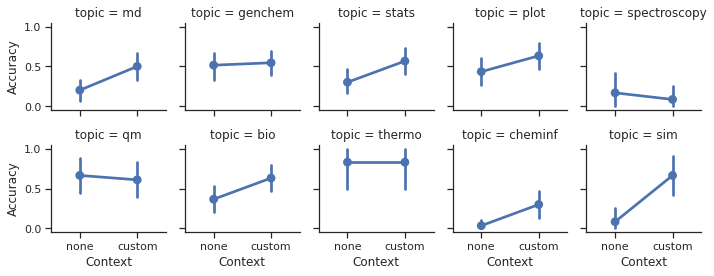

In [109]:
sns.set_theme(style="ticks")
sns.set_context('notebook')
plt.figure(figsize=(4,4), dpi=90)
g = sns.FacetGrid(merged, col='topic', col_wrap=5, height=2)
g.map(sns.pointplot, 'used_context', 'Result')
g.set_axis_labels('Context', 'Accuracy')

In [69]:
merged[merged.topic == 'md']

,name,Result_x,Result_y,language,context,topic,type,natlang,used_context
0,unbdistance,0.0,1.0,python,mdtraj,md,code,en,context
1,unbdistance,0.0,1.0,python,mdtraj,md,code,en,context
2,unbdistance,0.0,0.0,python,mdtraj,md,code,en,context
3,unbdistance,1.0,1.0,python,mdtraj,md,code,en,context
4,unbdistance,1.0,1.0,python,mdtraj,md,code,en,context
...,...,...,...,...,...,...,...,...,...
562,mapping_operator,0.0,0.0,python,MDAnalysis,md,code,en,context
563,mapping_operator,0.0,0.0,python,MDAnalysis,md,code,en,context
564,mapping_operator,0.0,0.0,python,MDAnalysis,md,code,en,context
565,mapping_operator,0.0,0.0,python,MDAnalysis,md,code,en,context
